In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# File paths
airbnb_file = "../data/airbnb.csv"
rentals_file = "../data/rentals.json"
geo_postcodes_file = "../data/geo/post_codes.geojson"

# Load data
airbnb_data = pd.read_csv(airbnb_file)
rental_data = pd.read_json(rentals_file)
geojson_data = gpd.read_file(geo_postcodes_file)



In [4]:
geojson_data

,geo_point_2d,pc4_code,year,gem_code,prov_code,prov_name,gem_name,geometry
0,"{ ""lon"": 4.8744295405900004, ""lat"": 52.3780276...",1052,2020,363,27,Noord-Holland,Amsterdam,"POLYGON ((4.88339 52.38702, 4.88338 52.387, 4...."
1,"{ ""lon"": 4.99293770354, ""lat"": 52.308466568500...",1108,2020,363,27,Noord-Holland,Amsterdam,"POLYGON ((4.99756 52.31826, 4.99764 52.31807, ..."
2,"{ ""lon"": 4.9289543170299996, ""lat"": 52.4467780...",1121,2020,415,27,Noord-Holland,Landsmeer,"POLYGON ((4.94869 52.48773, 4.94891 52.48769, ..."
3,"{ ""lon"": 5.1406948114100004, ""lat"": 52.2193452...",1216,2020,402,27,Noord-Holland,Hilversum,"POLYGON ((5.15169 52.22434, 5.1523 52.22416, 5..."
4,"{ ""lon"": 5.1568856690200002, ""lat"": 52.2394402...",1217,2020,402,27,Noord-Holland,Hilversum,"MULTIPOLYGON (((5.17144 52.22655, 5.17143 52.2..."
...,...,...,...,...,...,...,...,...
469,"{ ""lon"": 4.6369004432300001, ""lat"": 52.3819396...",2019,2020,392,27,Noord-Holland,Haarlem,"MULTIPOLYGON (((4.63646 52.37797, 4.63644 52.3..."
470,"{ ""lon"": 4.6589518775199998, ""lat"": 52.4217075...",2026,2020,392,27,Noord-Holland,Haarlem,"POLYGON ((4.65604 52.42842, 4.65635 52.42834, ..."
471,"{ ""lon"": 4.6533222423199998, ""lat"": 52.3797312...",2032,2020,392,27,Noord-Holland,Haarlem,"MULTIPOLYGON (((4.66293 52.38225, 4.66291 52.3..."
472,"{ ""lon"": 4.6611987482500004, ""lat"": 52.3665557...",2035,2020,392,27,Noord-Holland,Haarlem,"MULTIPOLYGON (((4.64094 52.35582, 4.64057 52.3..."


In [63]:

# Ensure 'price' column in airbnb_data is numeric
airbnb_data["price"] = pd.to_numeric(airbnb_data["price"], errors="coerce")

# Function to clean rent values
def clean_rent(value):
    if isinstance(value, str):
        # Extract the first sequence of digits (e.g., "500" from "€ 500,-")
        match = re.search(r'\d+', value.replace(",", "").replace(".", ""))
        if match:
            return float(match.group())
    return None  # Return None if no valid rent value is found

# Apply cleaning function to the 'rent' column
rental_data["rent"] = rental_data["rent"].apply(clean_rent)

# Ensure 'rent' column in rental_data is numeric
rental_data["rent"] = pd.to_numeric(rental_data["rent"], errors="coerce")

# Convert 'zipcode' and 'postalCode' to string type for consistency
rental_data["postalCode"] = rental_data["postalCode"].astype(str)
geojson_data["zipcode"] = geojson_data["pc4_code"].astype(str)

# Calculate potential revenue per postcode
airbnb_revenue = airbnb_data.groupby("zipcode")["price"].mean().reset_index()
rental_revenue = rental_data.groupby("postalCode")["rent"].mean().reset_index()

# Check for mismatches in 'zipcode' and 'postalCode'
missing_postal_codes = set(geojson_data["zipcode"]) - set(rental_revenue["postalCode"])
if missing_postal_codes:
    print("The following zipcodes are missing in rental_revenue:", missing_postal_codes)

# Merge Airbnb revenue with GeoJSON data
airbnb_geo = geojson_data.merge(airbnb_revenue, left_on="zipcode", right_on="zipcode", how="left")

# Merge rental revenue with GeoJSON data
rental_geo = geojson_data.merge(rental_revenue, left_on="zipcode", right_on="postalCode", how="left")

# Debugging rental_geo for null values
missing_rentals = rental_geo[rental_geo["rent"].isnull()]
if not missing_rentals.empty:
    print("Missing rentals detected in the merged data:")
    print(missing_rentals)

# Ensure all NaN rents are correctly handled
rental_geo["rent"].fillna(0, inplace=True)

The following zipcodes are missing in rental_revenue: {'1081', '1541', '1623', '1642', '1711', '2116', '1484', '1688', '1663', '1796', '1658', '1101', '2155', '1627', '1697', '1846', '1662', '1117', '1105', '1749', '1087', '2111', '1827', '1687', '2071', '1901', '2025', '1617', '2036', '1817', '1398', '1534', '1091', '1831', '1825', '1935', '1033', '1071', '1622', '1641', '1991', '1021', '1823', '2104', '1454', '1502', '1046', '1511', '1145', '1525', '1421', '1185', '1945', '1723', '1241', '1276', '1683', '2065', '3625', '1411', '1506', '1482', '1262', '2061', '1646', '1976', '1691', '1182', '1062', '1985', '1221', '1068', '1443', '1794', '1463', '1277', '1019', '1045', '1057', '1716', '2012', '1384', '1783', '2144', '2158', '1072', '1791', '1797', '1212', '1017', '1412', '2105', '1609', '2011', '1942', '1119', '1738', '1509', '1813', '1505', '2037', '1086', '1841', '1843', '1243', '2022', '1141', '1069', '1047', '1051', '1715', '1648', '1643', '2015', '1718', '1216', '1189', '1702', '

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_96289/1185288395.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rental_geo["rent"].fillna(0, inplace=True)


<Figure size 1200x800 with 0 Axes>

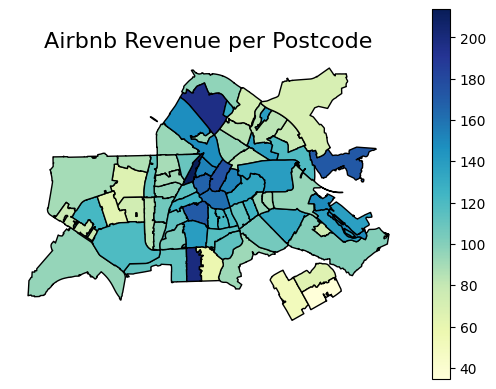

In [64]:
# Plot Airbnb revenue per postcode
plt.figure(figsize=(12, 8))
airbnb_geo.plot(column="price", cmap="YlGnBu", legend=True, edgecolor="black")
plt.title("Airbnb Revenue per Postcode", fontsize=16)
plt.axis("off")
plt.show( )

# Distribution of Airbnb Prices

Objective: Understand the spread and typical price range of Airbnb listings.

•	Plot a histogram of Airbnb prices.

•	Use box plots to visualize outliers.

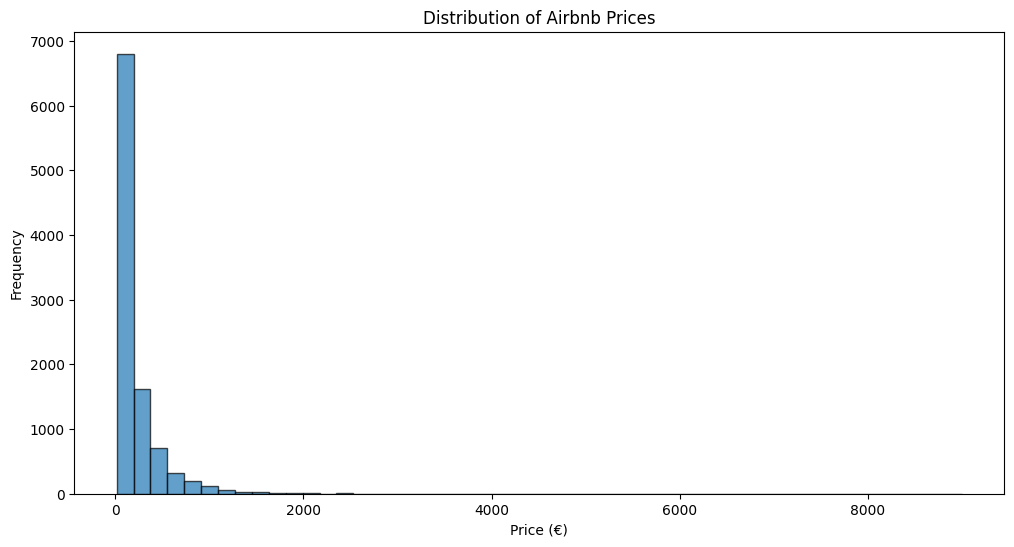

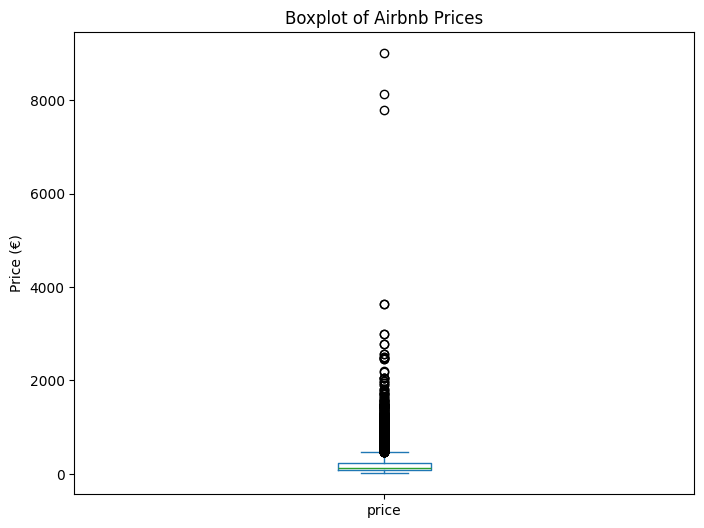

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
airbnb_data["price"].plot(kind="hist", bins=50, edgecolor="black", alpha=0.7)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.show()

# Boxplot for outliers
plt.figure(figsize=(8, 6))
airbnb_data["price"].plot(kind="box")
plt.title("Boxplot of Airbnb Prices")
plt.ylabel("Price (€)")
plt.show()

1.	Histogram of Airbnb Prices:

	•	The distribution of Airbnb prices is highly right-skewed, with the majority of listings priced below €500.

	•	A small number of listings have prices exceeding €1000, which are likely luxury or premium accommodations.
2.	Boxplot of Airbnb Prices:
	
    •	The boxplot confirms the presence of significant outliers in the dataset, with several listings priced well above the median.
	
    •	The interquartile range (IQR) is relatively small, indicating that most listings fall within a similar price range.

- Recommendations:

	•	Further investigation is needed for outliers (listings priced above €3000) to determine if they represent unique market segments (luxury stays) or data inconsistencies.

	•	This insight suggests focusing on the typical price range (€100–€500) for general market analysis and strategies.

# Rental Price Distribution

Objective: Analyze the spread and variability in rental prices.

	•	Plot a histogram and box plot for rental prices.

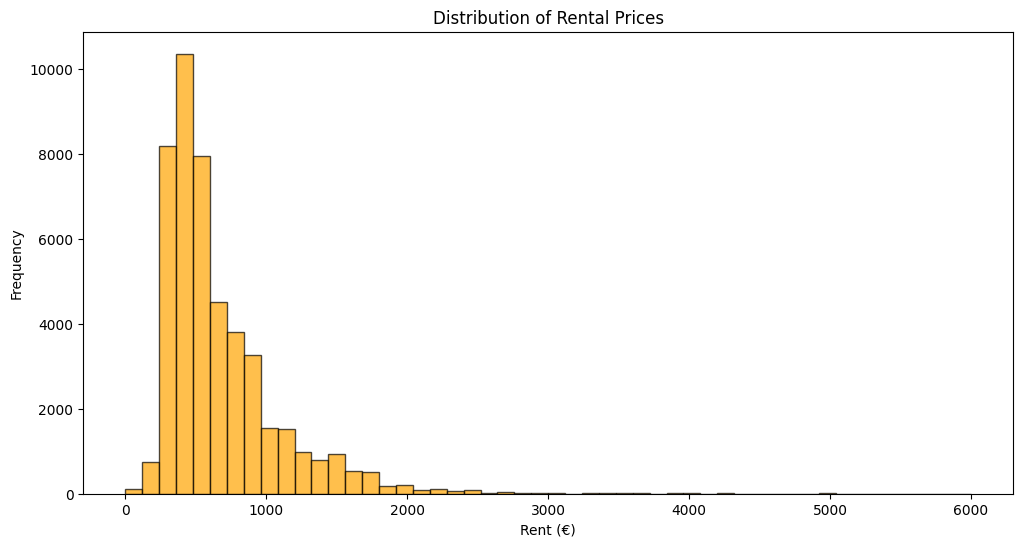

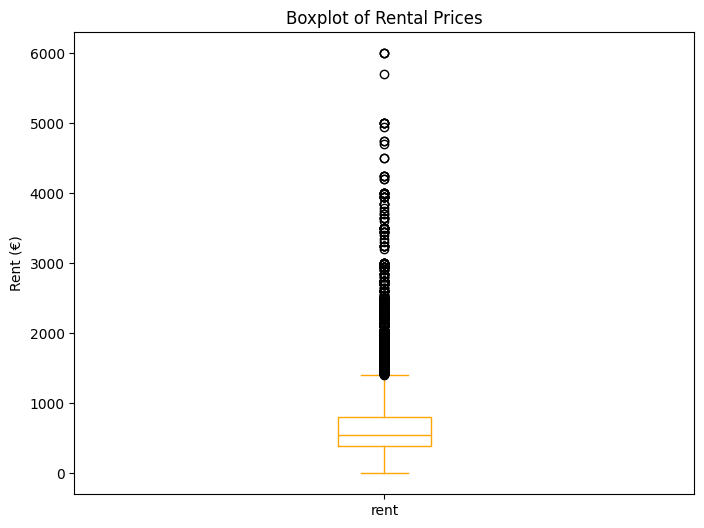

In [21]:
plt.figure(figsize=(12, 6))
rental_data["rent"].plot(kind="hist", bins=50, edgecolor="black", alpha=0.7, color="orange")
plt.title("Distribution of Rental Prices")
plt.xlabel("Rent (€)")
plt.ylabel("Frequency")
plt.show()

# Boxplot for outliers
plt.figure(figsize=(8, 6))
rental_data["rent"].plot(kind="box", color="orange")
plt.title("Boxplot of Rental Prices")
plt.ylabel("Rent (€)")
plt.show()

1.	Histogram of Rental Prices:

	•	The majority of rental prices are concentrated between €500 and €1000, with a significant peak around the €700–€800 range.
    
	•	There are very few properties with rents exceeding €2000, indicating that high-rent properties are rare in this dataset.

2.	Boxplot of Rental Prices:

	•	The boxplot confirms that rental prices have a skewed distribution with a long tail towards higher prices, reflecting the presence of outliers.

	•	Most properties fall within the interquartile range (IQR) of €500–€1000, with a median rental price slightly below €800.
	
    •	The presence of several outliers above €2000 suggests that some rental properties are priced significantly higher, which might indicate premium or luxury listings.

- Implications:

	•	The data suggests that the rental market is heavily dominated by properties in the affordable to mid-range price segments.
    
	•	The presence of outliers might require further investigation to understand whether these high-priced properties offer unique amenities, larger spaces, or are located in premium areas.

# Airbnb Prices vs Rental Prices

Objective: Compare the revenue potential of Airbnb and rentals.

	•	Create a scatter plot comparing Airbnb prices and rental prices by postcode.

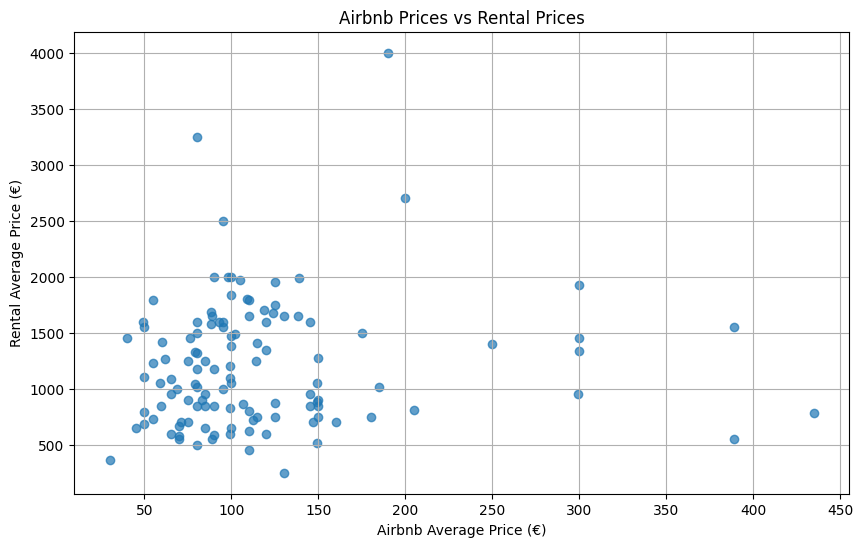

In [22]:
combined_revenue = airbnb_revenue.merge(rental_revenue, left_on="zipcode", right_on="postalCode", how="inner")
plt.figure(figsize=(10, 6))
plt.scatter(combined_revenue["price"], combined_revenue["rent"], alpha=0.7)
plt.title("Airbnb Prices vs Rental Prices")
plt.xlabel("Airbnb Average Price (€)")
plt.ylabel("Rental Average Price (€)")
plt.grid(True)
plt.show()

1.	Weak Correlation:

	•	The points are widely scattered, indicating a weak or negligible correlation between Airbnb and rental prices. This aligns with the earlier observation of a low correlation coefficient (~0.077).

2.	Airbnb Prices Concentration:

	•	Most Airbnb prices are concentrated between €50 and €200. This suggests that short-term rental properties are typically priced within this range, regardless of the corresponding long-term rental prices.

3.	Diverse Rental Prices:

	•	Rental prices show a broader distribution, ranging from below €500 to above €4,000. This reflects the variability in rental markets due to factors such as property type, location, and target audience.

4.	High Rental Price Outliers:

	•	A few locations exhibit extremely high rental prices (e.g., €3,000–€4,000), while Airbnb prices in the same locations remain moderate. These outliers could represent premium properties or areas with strong long-term housing demand.

5.	No Clear Clusters:

	•	The lack of distinct clusters suggests that there is no clear relationship or grouping between Airbnb and rental prices, reinforcing the idea that these markets may operate independently.

6.	Implication for Investors:

	•	Investors should not assume that high long-term rental prices necessarily translate to high Airbnb revenues or vice versa. Each market requires separate analysis to identify revenue potential.

# Revenue Contribution by City

Objective: Find the cities contributing most to Airbnb and rental revenues.

	•	Group by city and calculate total Airbnb and rental revenues.

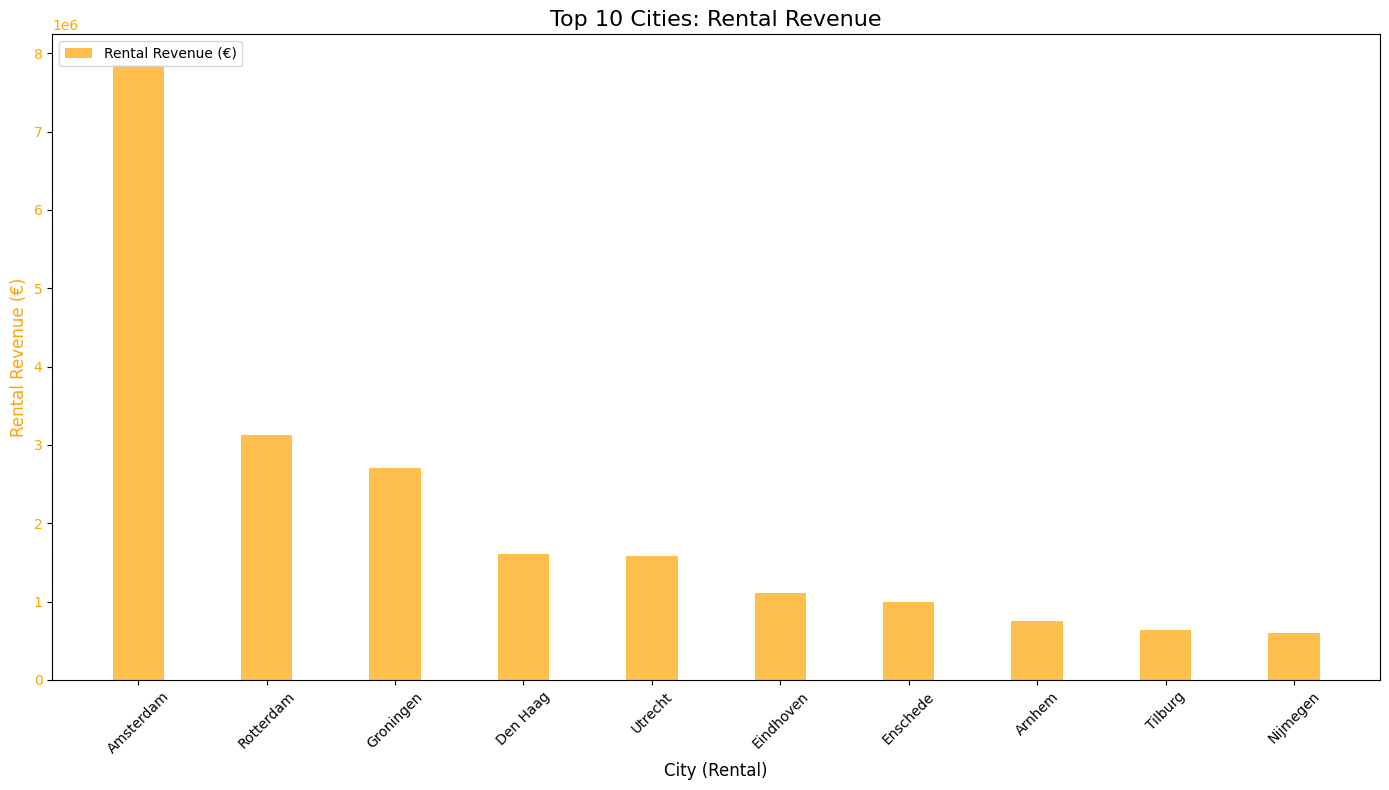

In [34]:

# Extract relevant columns from rental data
rental_locations = rental_data[["latitude", "longitude", "city"]].copy()

# Convert latitude and longitude to numeric for both datasets
airbnb_data["latitude"] = pd.to_numeric(airbnb_data["latitude"], errors="coerce")
airbnb_data["longitude"] = pd.to_numeric(airbnb_data["longitude"], errors="coerce")
rental_locations["latitude"] = pd.to_numeric(rental_locations["latitude"], errors="coerce")
rental_locations["longitude"] = pd.to_numeric(rental_locations["longitude"], errors="coerce")

# Perform the left join to add city information to Airbnb data
airbnb_data_with_city = airbnb_data.merge(
    rental_locations,
    on=["latitude", "longitude"],
    how="left"
)


city_airbnb_revenue = airbnb_data_with_city.groupby("city")["price"].sum().sort_values(ascending=False).reset_index()
city_rental_revenue = rental_data.groupby("city")["rent"].sum().sort_values(ascending=False).reset_index()

# Sort data to get top cities by Airbnb and rental revenue
top_airbnb_revenue = city_airbnb_revenue.sort_values(by="price", ascending=False).head(10)  # Top 10 for Airbnb
top_rental_revenue = city_rental_revenue.sort_values(by="rent", ascending=False).head(10)  # Top 10 for rentals



# Plot for Top Rental Revenue Cities
fig, ax2 = plt.subplots(figsize=(14, 8))

x_rental = range(len(top_rental_revenue))  # Create x-axis positions for rental data

# Plot rental revenue on the primary y-axis
ax2.bar(
    x_rental,
    top_rental_revenue["rent"],
    width=0.4,
    label="Rental Revenue (€)",
    color="orange",
    alpha=0.7,
)
ax2.set_ylabel("Rental Revenue (€)", fontsize=12, color="orange")
ax2.tick_params(axis="y", labelcolor="orange")
ax2.set_xlabel("City (Rental)", fontsize=12)

# Add city names as x-ticks
ax2.set_xticks(x_rental)
ax2.set_xticklabels(top_rental_revenue["city"], rotation=45)

# Add title
plt.title("Top 10 Cities: Rental Revenue", fontsize=16)

# Add legend for Rentals
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

1.	Dominance of Amsterdam:

	•	Amsterdam leads with a significant margin, generating the highest rental revenue compared to other cities. This reflects its status as a prime location for housing demand, likely driven by tourism, business activities, and high property values.

2.	Top Contenders:

	•	Rotterdam and Groningen follow, with Rotterdam generating approximately half of Amsterdam’s revenue. Groningen also shows strong performance, suggesting a combination of student housing and local demand.

3.	Mid-Tier Cities:

	•	Cities like Den Haag, Utrecht, and Eindhoven form the mid-tier revenue generators. These cities likely benefit from being regional hubs with significant populations and demand for rentals.

4.	Smaller Contributors:

	•	Cities such as Arnhem, Tilburg, and Nijmegen generate lower revenue compared to the top-performing cities. These areas may have less demand or lower rental prices, contributing to the smaller figures.

5.	Implications:

	•	Investors targeting high rental returns may focus on cities like Amsterdam and Rotterdam.
    
	•	The chart reflects the geographic distribution of rental revenue potential, highlighting key regions with strong housing markets.

# Revenue Potential by Postcode

Objective: Highlight postcodes with the highest revenue potential for Airbnb and rentals.

	•	Identify the top 10 postcodes for Airbnb and rental revenue.

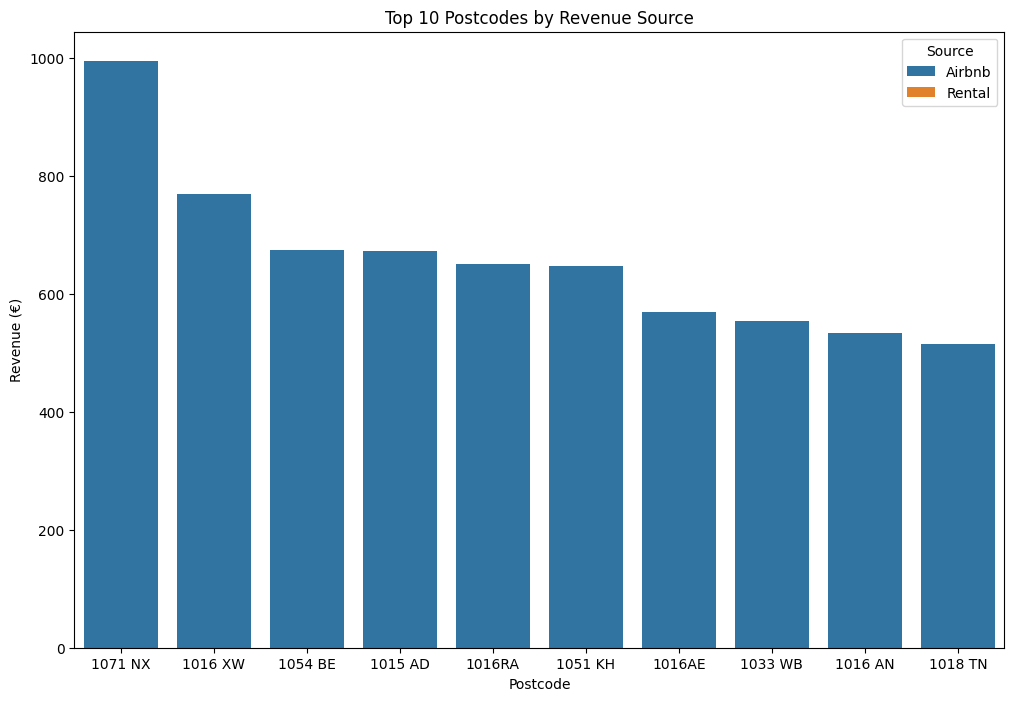

In [35]:
top_airbnb_revenue = airbnb_revenue.sort_values(by="price", ascending=False).head(10)
top_rental_revenue = rental_revenue.sort_values(by="rent", ascending=False).head(10)

# Combine and plot
top_revenue = pd.concat(
    [
        top_airbnb_revenue.assign(Source="Airbnb"),
        top_rental_revenue.assign(Source="Rental"),
    ]
)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_revenue, x="zipcode", y="price", hue="Source")
plt.title("Top 10 Postcodes by Revenue Source")
plt.xlabel("Postcode")
plt.ylabel("Revenue (€)")
plt.show()

1.	Top Revenue-Generating Postcodes:

	•	The postcode 1071 NX stands out as the highest revenue generator, reflecting significant demand or higher pricing in this area.

	•	Other postcodes, such as 1016 XW and 1054 BE, also exhibit strong revenue performance but are notably lower than the top-performing postcode.

2.	Revenue Concentration:

	•	The revenue disparity between the top postcode (1071 NX) and the others suggests a concentrated revenue stream in certain high-demand or premium areas.

    •	The mid-range postcodes, such as 1051 KH and 1016 RA, generate comparable revenues, indicating similar market demand or pricing strategies.

3.	Potential Drivers:

	•	Higher revenues in specific postcodes could be attributed to factors such as proximity to city centers, tourist attractions, or availability of premium accommodations.
    
	•	Local rental and Airbnb pricing dynamics, along with demand, may influence the revenue variations between these postcodes.

# Room Type Revenue Analysis

Objective: Understand which room types generate the most revenue for Airbnb.

	•	Group by room_type and calculate total and average revenue.

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_96289/274112498.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=room_type_revenue, x="room_type", y="mean", palette="viridis")


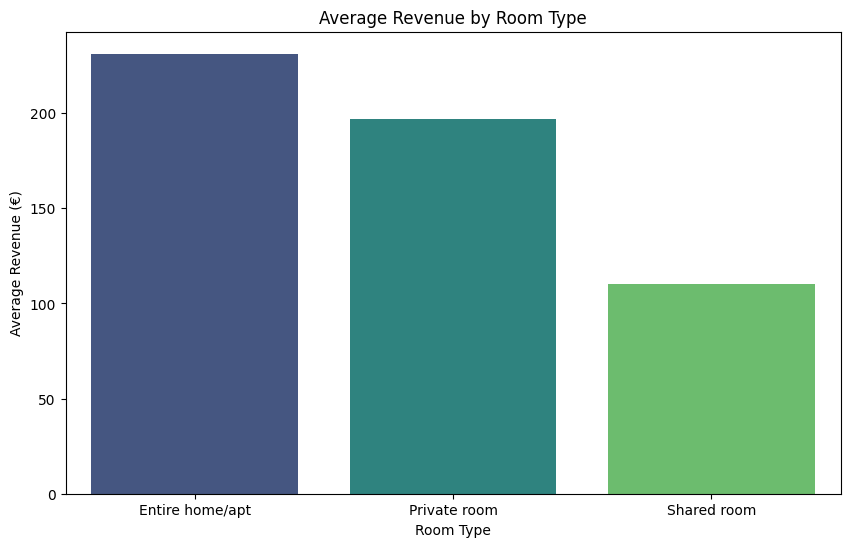

In [38]:
room_type_revenue = airbnb_data.groupby("room_type")["price"].agg(["sum", "mean"]).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=room_type_revenue, x="room_type", y="mean", palette="viridis")
plt.title("Average Revenue by Room Type")
plt.xlabel("Room Type")
plt.ylabel("Average Revenue (€)")
plt.show()

1.	Revenue Distribution:

	•	Entire home/apartment listings generate the highest average revenue compared to other room types. This is likely because they offer more privacy and amenities, catering to larger groups or families.

	•	Private rooms fall in the mid-range for revenue, appealing to budget-conscious travelers who still want some level of privacy.

	•	Shared rooms have the lowest average revenue, reflecting their affordability and appeal to cost-sensitive individuals or backpackers.

2.	Demand and Pricing:

	•	The significant revenue gap between “Entire home/apartment” and “Shared room” indicates higher pricing and demand for entire accommodations.

	•	Private rooms strike a balance between affordability and comfort, making them popular among solo travelers or couples.

3.	Strategic Implications:

	•	Hosts offering “Entire home/apartment” listings can focus on enhancing the value proposition to maintain higher revenue.
    
	•	For private rooms and shared rooms, competitive pricing and unique offerings (e.g., local experiences, amenities) can help attract more bookings.

# Spatial Analysis Using Maps

Objective: Visualize the spatial distribution of revenues.

	•	Use a geographic plotting library like GeoPandas or Folium.

<Figure size 1000x800 with 0 Axes>

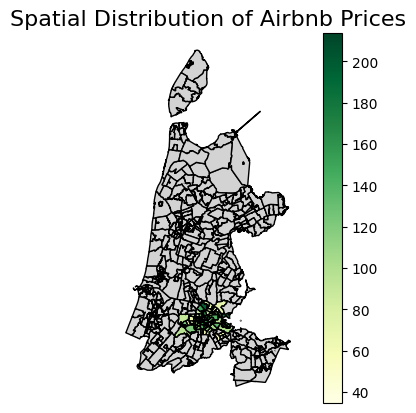

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure geojson_data is already a GeoDataFrame
geojson_gdf = gpd.GeoDataFrame(geojson_data, geometry="geometry")

# Merge with Airbnb data for prices (if required)
geojson_gdf = geojson_gdf.merge(airbnb_geo[["zipcode", "price"]], on="zipcode", how="left")

# Plot spatial distribution of Airbnb prices
plt.figure(figsize=(10, 8))
geojson_gdf.plot(
    column="price",
    cmap="YlGn",
    legend=True,
    edgecolor="black",
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)
plt.title("Spatial Distribution of Airbnb Prices", fontsize=16)
plt.axis("off")
plt.show()

<Figure size 1000x800 with 0 Axes>

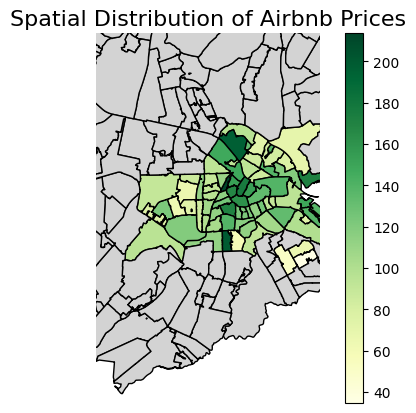

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure geojson_data is already a GeoDataFrame
geojson_gdf = gpd.GeoDataFrame(geojson_data, geometry="geometry")

# Merge with Airbnb data for prices (if required)
geojson_gdf = geojson_gdf.merge(airbnb_geo[["zipcode", "price"]], on="zipcode", how="left")

# Plot spatial distribution of Airbnb prices
plt.figure(figsize=(10, 8))
ax = geojson_gdf.plot(
    column="price",
    cmap="YlGn",
    legend=True,
    edgecolor="black",
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Set title
plt.title("Spatial Distribution of Airbnb Prices", fontsize=16)

# Zoom in by setting axis limits (adjust these to focus on your area of interest)
# For example, Amsterdam area
plt.xlim(4.7, 5.0)  # Longitude range
plt.ylim(52.2, 52.5)  # Latitude range

# Remove axis for cleaner visualization
plt.axis("off")

plt.show()

1.	Price Clusters:

	•	Areas shaded in darker green represent regions with higher Airbnb prices, likely reflecting central or high-demand locations such as tourist hotspots or neighborhoods with premium amenities.

	•	Lighter green or yellowish areas indicate regions with lower Airbnb prices, which may be further from central locations or less popular among short-term visitors.

2.	Centralization of High Prices:

	•	The core areas on the map appear to have the highest Airbnb prices, consistent with central urban areas typically attracting higher demand due to proximity to attractions, business centers, or transportation hubs.

3.	Outer Regions:

	•	The outer areas show a drop in Airbnb prices, potentially reflecting suburban or less tourist-driven locations. These areas may cater more to long-term stays or have less competitive pricing compared to the central regions.

4.	Actionable Insight:

	•	Hosts can optimize pricing strategies by analyzing demand patterns in specific neighborhoods. For areas with high prices, offering premium services can enhance value, while regions with lower prices can focus on affordability and targeted marketing to attract budget-conscious travelers.

# Correlation Between Airbnb and Rental Prices

Objective: Identify the relationship between Airbnb and rental prices.

	•	Calculate and visualize the correlation between Airbnb and rental revenues.

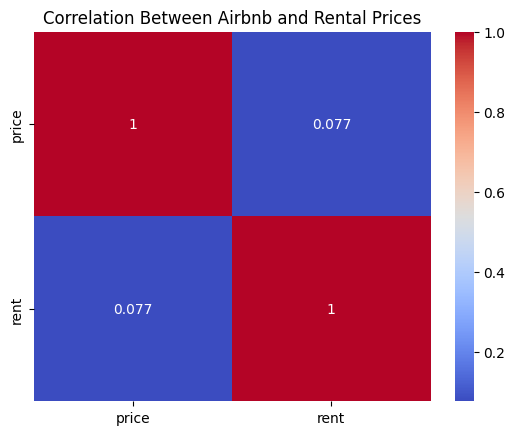

In [51]:
correlation = combined_revenue[["price", "rent"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Between Airbnb and Rental Prices")
plt.show()

1.	Correlation Coefficients:

	•	The heatmap shows the correlation matrix for Airbnb prices (price) and rental prices (rent).

	•	A value of 1 on the diagonal indicates a perfect correlation of each variable with itself.

	•	The off-diagonal value (0.077) represents the correlation between Airbnb prices and rental prices, suggesting a very weak positive relationship between the two variables.

2.	Interpretation of Correlation:

	•	A correlation of 0.077 implies that Airbnb prices and rental prices are not strongly correlated, suggesting that factors influencing Airbnb pricing (e.g., short-term demand, tourist attraction) differ significantly from those driving long-term rental prices (e.g., local housing market, long-term contracts).

3.	Actionable Insight:

	•	This weak correlation suggests that using rental prices to predict Airbnb prices (or vice versa) is unlikely to yield accurate results. It highlights the need to consider separate factors and datasets when optimizing Airbnb or rental strategies.

# Identify Underpriced Areas

Objective: Find areas where Airbnb prices are significantly lower than expected based on rentals.

	•	Calculate a price ratio and flag outliers.

In [52]:
combined_revenue["price_ratio"] = combined_revenue["price"] / combined_revenue["rent"]
underpriced_areas = combined_revenue[combined_revenue["price_ratio"] < 1]

print(underpriced_areas)

    zipcode       price postalCode    rent  price_ratio
0    1011BJ  147.000000     1011BJ   700.0     0.210000
1    1011JT  139.000000     1011JT  1988.0     0.069920
2    1011LJ   88.000000     1011LJ  1575.0     0.055873
3    1012AE  138.000000     1012AE  1650.0     0.083636
4    1012ES  190.000000     1012ES  4000.0     0.047500
..      ...         ...        ...     ...          ...
113  1095VB   93.000000     1095VB  1600.0     0.058125
114  1096GG  106.666667     1096GG   863.4     0.123543
115  1096GJ   62.000000     1096GJ  1262.5     0.049109
116  1102AA   30.000000     1102AA   360.0     0.083333
117  1103RA   70.000000     1103RA   575.0     0.121739

[118 rows x 5 columns]


1. Examples of Observations:

	•	For zipcode 1011BJ, the price ratio is 0.21, indicating that Airbnb can recover 21% of the monthly rental cost in a single day.

	•	In contrast, zipcode 1011LJ has a lower ratio of 0.0559, indicating that Airbnb generates only 5.6% of the monthly rental price in one day, making rentals potentially more stable in this area.

	•	zipcode 1102AA has a very low Airbnb price of €30 but a correspondingly low monthly rent of €360, resulting in a moderate price ratio of 0.0833.

2. High and Low Airbnb Revenue Areas:

	•	Zipcodes with higher price values (e.g., 1012ES at €190) might be more favorable for short-term Airbnb rentals.

	•	Areas with lower Airbnb prices but higher rents (e.g., 1096GJ at €62 with a rent of €1262.5) may not be as attractive for Airbnb operations.

3. Balanced Areas:

	•	Some zipcodes have a relatively balanced price_ratio, such as 1096GG (price: €106.67, rent: €863.4, ratio: 0.1235), making them viable for both short-term and long-term rentals depending on demand.